In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
epochs = 300
batch_size = 100
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('다음 장치를 사용합니다:', device)

다음 장치를 사용합니다: cuda


In [3]:
trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
]))

train_loader = torch.utils.data.DataLoader(dataset= trainset, batch_size=batch_size, shuffle=True)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [13]:
D = nn.Sequential(
    nn.Linear(784, 1024),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [14]:
# 모델의 가중치를 지정한 장치로 보내기
G = G.to(device)
D = D.to(device)

criterion = nn.BCELoss() # 이진 교차 엔트로피 오차 함수
g_optimizer = optim.Adam(G.parameters(), lr=0.0002) # 생성자와 판별자를 최적화할 Adam 모듈
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [15]:
total_step = len(train_loader)

for epoch in range(1, epochs + 1):
  for i, (images, _) in enumerate(train_loader):
    images = images.reshape(batch_size, -1).to(device)
    
    # '진짜'와 '가짜' 레이블 생성
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # 무작위 텐서로 가짜 이미지 생성
    z = torch.randn(batch_size, 64).to(device)
    fake_images = G(z)

    # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # 진짜 이미지 오차와 가짜 이미지 오차를 더해서 판별자의 오차 계산
    d_loss = d_loss_real + d_loss_fake

    # 역전파 알고리즘으로 판별자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    # 생성자가 판별자를 속였는지에 대한 오차 계산
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)
    
    # 역전파 알고리즘으로 생성자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

  print('Epoch [{}/{}] d_loss: {:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)): {:.2f}'.format(
                  epoch, epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()
    ))

Epoch [1/300] d_loss: 0.1739 g_loss: 7.5644 D(x):0.95 D(G(z)): 0.07
Epoch [2/300] d_loss: 0.8061 g_loss: 3.2000 D(x):0.78 D(G(z)): 0.25
Epoch [3/300] d_loss: 0.4048 g_loss: 4.4240 D(x):0.89 D(G(z)): 0.08
Epoch [4/300] d_loss: 0.5576 g_loss: 4.2992 D(x):0.83 D(G(z)): 0.11
Epoch [5/300] d_loss: 0.4790 g_loss: 3.1529 D(x):0.84 D(G(z)): 0.12
Epoch [6/300] d_loss: 0.7791 g_loss: 2.8549 D(x):0.75 D(G(z)): 0.18
Epoch [7/300] d_loss: 0.5473 g_loss: 2.5213 D(x):0.82 D(G(z)): 0.19
Epoch [8/300] d_loss: 0.4540 g_loss: 2.8757 D(x):0.86 D(G(z)): 0.14
Epoch [9/300] d_loss: 0.8324 g_loss: 1.9387 D(x):0.73 D(G(z)): 0.23
Epoch [10/300] d_loss: 0.8007 g_loss: 1.6713 D(x):0.81 D(G(z)): 0.33
Epoch [11/300] d_loss: 0.7742 g_loss: 1.4119 D(x):0.75 D(G(z)): 0.31
Epoch [12/300] d_loss: 0.6749 g_loss: 1.6197 D(x):0.82 D(G(z)): 0.29
Epoch [13/300] d_loss: 0.6462 g_loss: 2.0260 D(x):0.73 D(G(z)): 0.18
Epoch [14/300] d_loss: 1.1862 g_loss: 1.6855 D(x):0.60 D(G(z)): 0.27
Epoch [15/300] d_loss: 0.7116 g_loss: 1.873

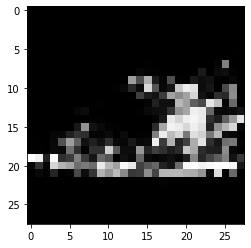

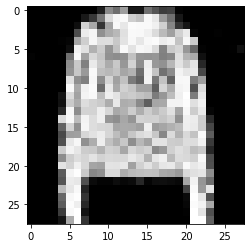

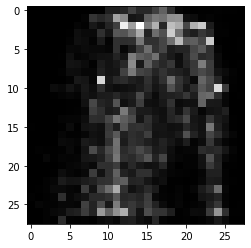

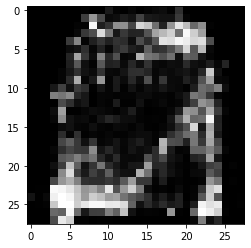

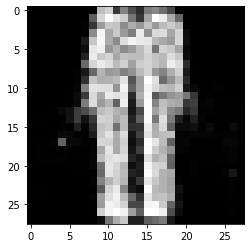

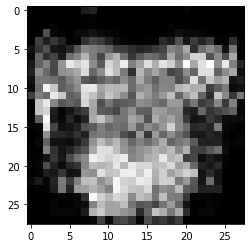

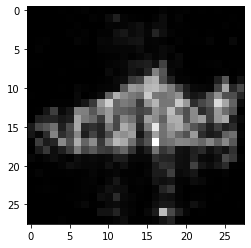

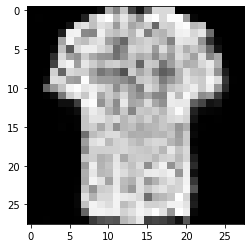

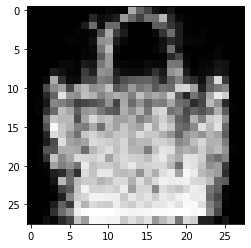

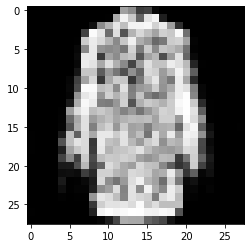

In [16]:
# 생성자가 만든 이미지 시각화
import numpy as np

z = torch.randn(batch_size, 64).to(device)
fake_images = G(z)
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.show()